In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from scipy.stats import ttest_rel

In [2]:
def add_label_to_df(df, path_to_labels):
    """Add label description to the input dataframe."""
    if Path(path_to_labels).is_dir():
        series_to_labels_mapping = {}
        for path in Path(path_to_labels).glob('*.json'):
            with open(path, 'r') as file:
                labels = json.load(file)
                series_to_labels_mapping.update({
                    f"{path.stem}": labels
                })
    elif Path(path_to_labels).is_file():
        with open(path_to_labels, 'r') as file:
            series_to_labels_mapping = json.load(file)
    else:
        raise ValueError(f"path_to_labels ''{path_to_labels}' must be file or directory'")
    labels_mapping_list = [
        {
            "series_uuid": series,
            "foreground_label": int(value),
            "label_description": ','.join([value_.lower().strip() for value_ in label.split(',')])
        }
        for series, mapping in series_to_labels_mapping.items()
        for value, label in mapping.items()
    ]
    labels_mapping_df = pd.DataFrame(labels_mapping_list)
    new_df = df.copy()
    new_df["series_uuid"] = new_df["ct_fname"].apply(lambda x: x.split('.nii.gz')[0])
    merged_df = new_df.merge(labels_mapping_df, on=["series_uuid", "foreground_label"], how='left')
    return merged_df

In [3]:
def concatenate_iteration_dfs(iteration_dfs, keep_only_common_between_iterations=True):
    """Return concatenated dataframes with the column 'iteration'
    added.

    Parameters
    ----------
    iteration_dfs : list
        Each item is a dictionary with the following keys:
            'path': path to the performance JSON file.
            'iteration': integer indicating the iteration.
    keep_only_common_between_iterations : bool, optional
        Remove rows with bounding boxes that are absent in at least one iteration.
        The resulting dataframe has rows with bounding boxes present in all iterations.
    """
    dfs = []
    for item in iteration_dfs:
        with open(item['path'], 'r') as file:
            df = pd.DataFrame(json.load(file)['bboxes'])
        df['iteration'] = item['iteration']
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True).sort_values(by='iteration')
    if keep_only_common_between_iterations:
        common_bboxes = set(concatenated_df['bbox_original_fname'])
        for iteration in concatenated_df['iteration'].unique():
            common_bboxes = common_bboxes.intersection(set(concatenated_df[concatenated_df['iteration'] == iteration]['bbox_original_fname']))
        concatenated_df = concatenated_df[concatenated_df['bbox_original_fname'].isin(common_bboxes)]
    return concatenated_df

In [4]:
def run_paired_t_test(performance_df, iteration_a = 0, iteration_b = 1):
    "Test the difference between the means of both iterations (iteration_b - iteration_a)."
    performance_df_subset = performance_df[(performance_df['iteration'] == iteration_a) | (performance_df['iteration'] == iteration_b)].copy()
    duplicated = performance_df_subset['bbox_original_fname'].duplicated(keep=False)
    filtered = performance_df_subset[duplicated]
    filtered_a = filtered[filtered['iteration'] == iteration_a].copy()
    filtered_b = filtered[filtered['iteration'] == iteration_b].copy()
    filtered_a.sort_values(by='bbox_original_fname', inplace=True)
    filtered_b.sort_values(by='bbox_original_fname', inplace=True)
    new_df = {
        f"index_iteration_{iteration_a}": filtered_a.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_a}": filtered_a['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_a}": filtered_a['dice_score'].to_list(),
        f"index_iteration_{iteration_b}": filtered_b.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_b}": filtered_b['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_b}": filtered_b['dice_score'].to_list()
    }
    new_df = pd.DataFrame(new_df)
    new_df['paired_sample'] = new_df.apply(
        lambda row: row[f"bbox_original_fname_iteration_{iteration_a}"] == row[f"bbox_original_fname_iteration_{iteration_b}"],
        axis=1
    )
    new_df['difference'] = new_df[f"dice_score_iteration_{iteration_a}"] - new_df[f"dice_score_iteration_{iteration_b}"]
    ttest_result = ttest_rel(
        new_df[f"dice_score_iteration_{iteration_b}"],
        new_df[f"dice_score_iteration_{iteration_a}"]
    )
    return ttest_result, new_df

# Evolución del desempeño de MedSAM mediante estrategia HITL
- El desempeño se mide sobre un conjunto de **15 volúmenes CT** (6 anotados por GP y 9 anotados por MF), correspondientes a **6 pacientes**:
    - 2208: cáncer de recto (3 estudios, 3 series anotadas)
    - 10980: cáncer de vejiga (3 estudios, 3 series anotadas)
    - 10976: cáncer de vesícula biliar (3 estudios, 3 series anotadas)
    - 10979: cáncer gástrico (2 estudios, 2 series anotadas)
    - 10978: cáncer de colon (2 estudios, 3 series anotadas)
    - 10991: melanoma (1 estudio, 1 serie anotada)
- La iteración 0 corresponde a la evaluación del modelo MedSAM sin ajuste con datos locales.
- La iteración 1 corresponde a la evaluación del modelo MedSAM ajustado sobre un conjunto de **13 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **4 pacientes**:
    - 1: cáncer gástrico (1 estudio, 2 series anotadas)
    - 2: cáncer gástrico (4 estudios, 6 series anotadas)
    - 3: cáncer de mama (2 estudios, 3 series anotadas)
    - 14: cáncer de pulmón (1 estudio, 2 series anotadas)

In [5]:
iteration_dfs = [
    {
        'path': Path.cwd() / "resources" / "HITL-iteration-0" / "test-evaluation" / "performance.json",
        'iteration': 0
    },
    {
        'path': Path.cwd() / "resources" / "HITL-iteration-1" / "test-evaluation" / "performance-cv-iteration-1-MedSAM-ViT-B-20240423-1349.json",
        'iteration': 1
    },
]
path_to_labels = Path.cwd() / "resources" / "labels-test"
performance_df = concatenate_iteration_dfs(iteration_dfs)
performance_df = add_label_to_df(performance_df, path_to_labels)

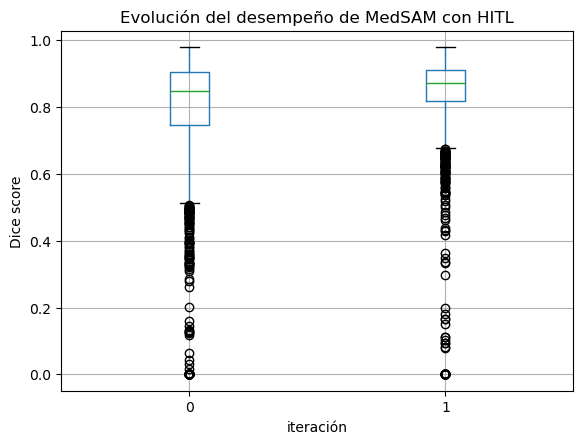

dice_score                                                         \
               count      mean       std  min       25%       50%       75%   
iteration                                                                     
0             3086.0  0.792890  0.181777  0.0  0.745830  0.847291  0.904386   
1             3086.0  0.838466  0.147359  0.0  0.817416  0.873594  0.911721   

                     
                max  
iteration            
0          0.978966  
1          0.979798

In [6]:
# Boxplot of Dice score for each iteration (all lesions)
performance_df.boxplot(column='dice_score', by='iteration')
plt.suptitle('')
plt.title('Evolución del desempeño de MedSAM con HITL')
plt.xlabel('iteración')
plt.ylabel('Dice score')
plt.show()
display(performance_df[['dice_score', 'iteration']].groupby('iteration').describe())

In [7]:
iterations = performance_df['iteration'].unique()
iterations_count = len(iterations)
lesion_types_count = len(performance_df['label_description'].unique())
print(f"# iteraciones: {iterations_count}")
print(f"# tipos de lesión: {lesion_types_count}")

# iteraciones: 2
# tipos de lesión: 9


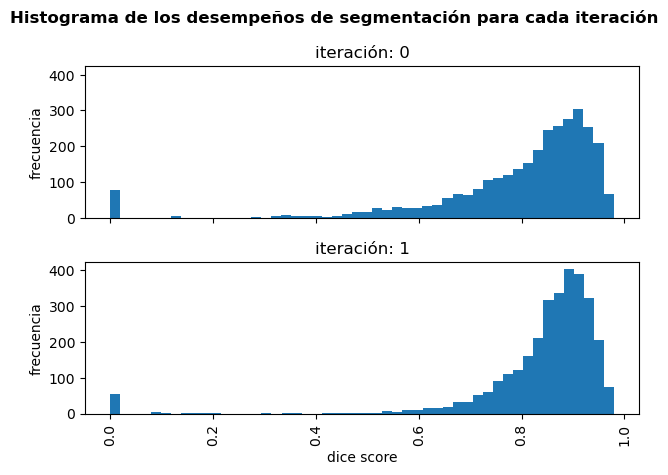

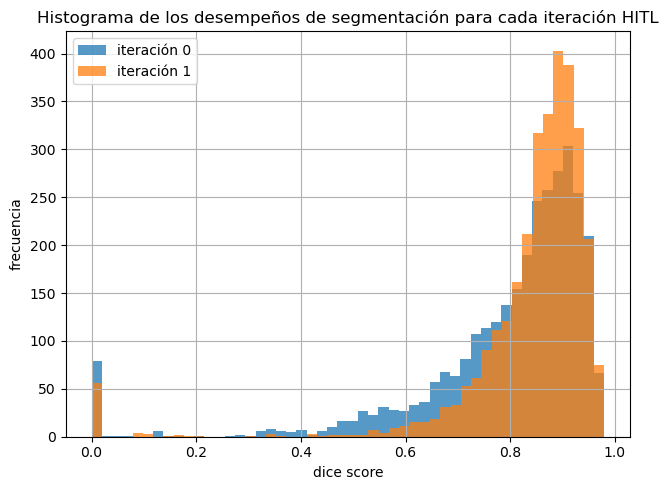

In [8]:
# Histogram of Dice score for each iteration (all lesions)
fig, ax = plt.subplots(nrows=iterations_count, ncols=1, sharex=True, sharey=True)
performance_df.hist(
    column='dice_score',
    by='iteration',
    bins=50,
    ax=ax
)
fig.suptitle('Histograma de los desempeños de segmentación para cada iteración', fontweight='bold')
for idx in range(iterations_count):
    ax[idx].set_ylabel('frecuencia')
    ax[idx].set_title(f"iteración: {iterations[idx]}")
ax[-1].set_xlabel('dice score')
plt.tight_layout()
plt.show()
# Overlapped histograms
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5,5))
cmap = plt.get_cmap('tab10')
for it in iterations:
    performance_df[performance_df['iteration'] == it].hist(
        column='dice_score',
        bins=50,
        ax=ax,
        color=cmap(it),
        alpha=0.75,
        label=f"iteración {it}"
    )
ax.legend()
ax.set_title('Histograma de los desempeños de segmentación para cada iteración HITL')
ax.set_xlabel('dice score')
ax.set_ylabel('frecuencia')
plt.tight_layout()
#plt.savefig(Path.cwd() / 'resources' / 'overlapped_histograms.png')
plt.show()

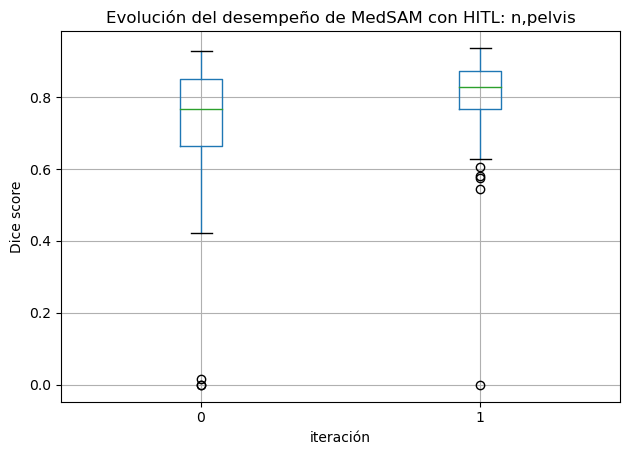

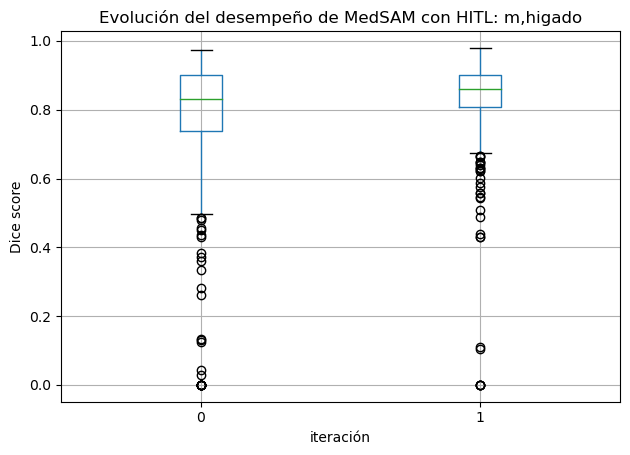

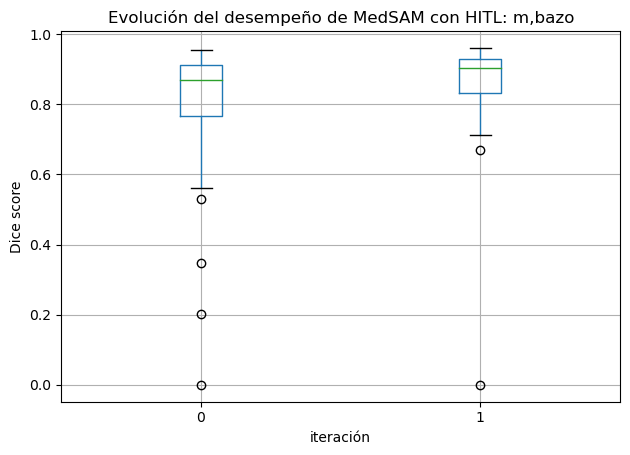

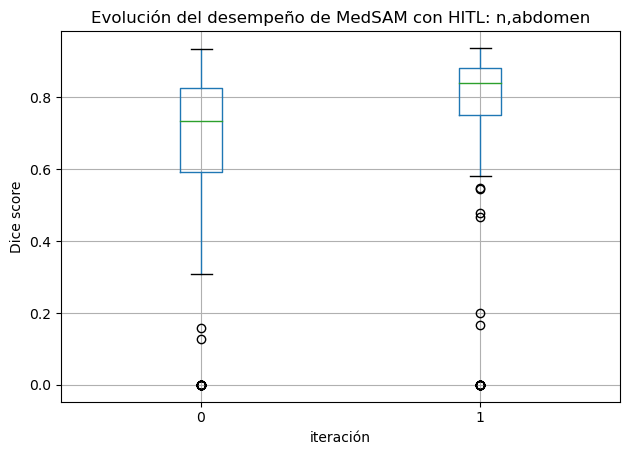

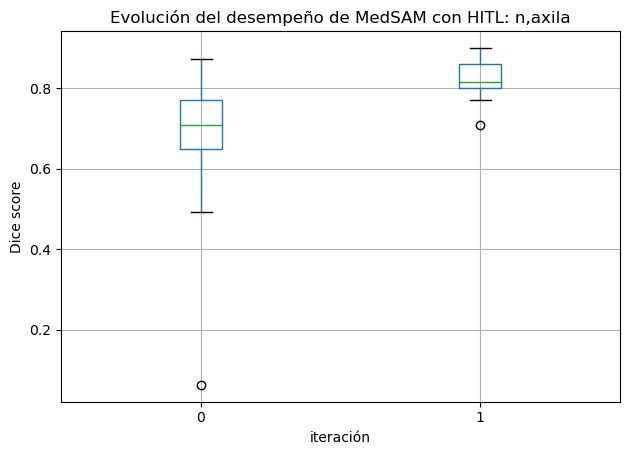

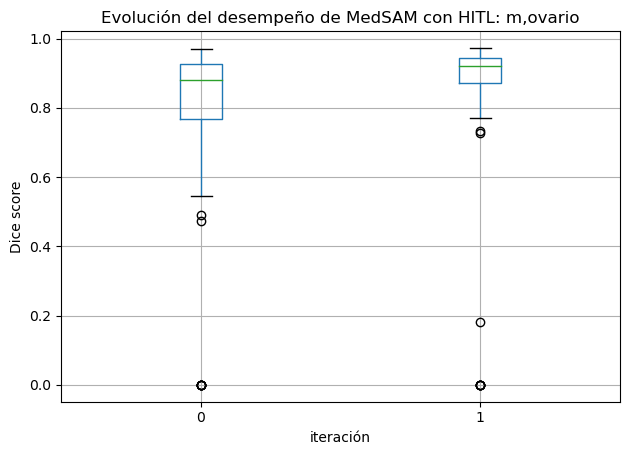

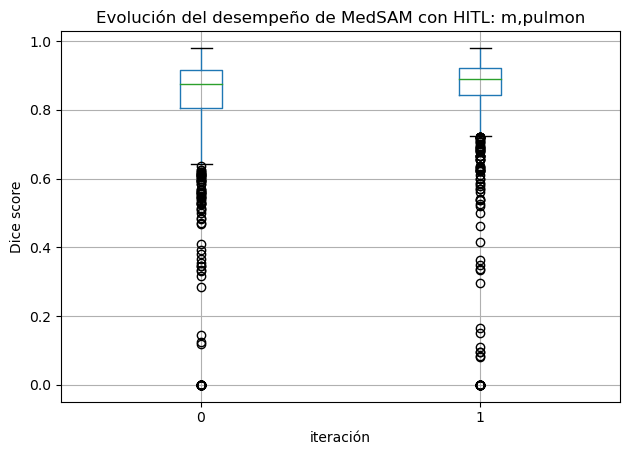

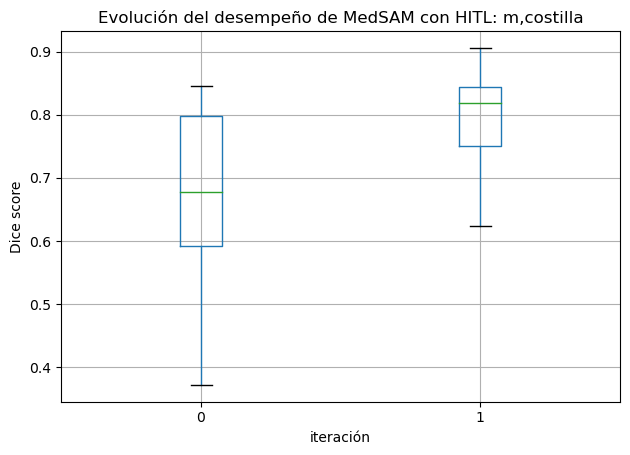

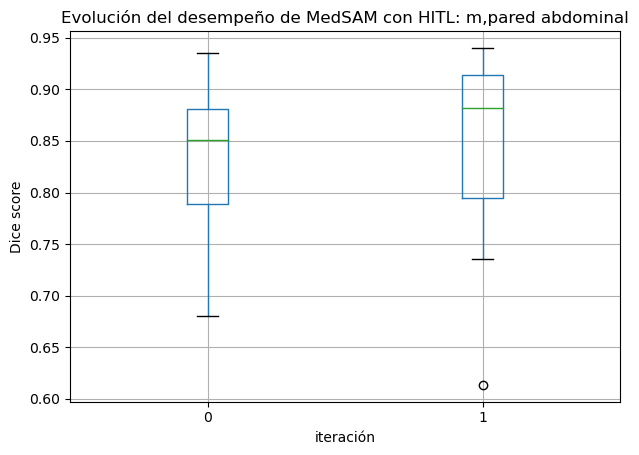

In [9]:
# Boxplot of Dice score for each iteration, dissagregated by lesion type
unique_lesions = list(performance_df['label_description'].unique())
for lesion in unique_lesions:
    performance_df[performance_df['label_description'] == lesion].boxplot(column='dice_score', by='iteration')
    plt.suptitle('')
    plt.title(f'Evolución del desempeño de MedSAM con HITL: {lesion}')
    plt.xlabel('iteración')
    plt.ylabel('Dice score')
    plt.tight_layout()
    plt.show()

In [10]:
display(performance_df.groupby(['label_description', 'iteration'])['dice_score'].describe())

count      mean       std       min       25%  \
label_description iteration                                                   
m,bazo            0            59.0  0.802740  0.181863  0.000000  0.767055   
                  1            59.0  0.861198  0.135360  0.000000  0.831052   
m,costilla        0            12.0  0.675509  0.141777  0.372240  0.591673   
                  1            12.0  0.797267  0.076222  0.623963  0.749927   
m,higado          0           745.0  0.790276  0.166670  0.000000  0.737374   
                  1           745.0  0.839763  0.112844  0.000000  0.807339   
m,ovario          0            89.0  0.787322  0.255064  0.000000  0.767013   
                  1            89.0  0.840138  0.245034  0.000000  0.870864   
m,pared abdominal 0            20.0  0.837178  0.069270  0.680556  0.788967   
                  1            20.0  0.850531  0.085483  0.613636  0.794356   
m,pulmon          0          1599.0  0.829590  0.164820  0.000000  0.804955   
                  1          1599.0  0.853661  0.146471  0.000000  0.842105   
n,abdomen         0           417.0  0.681598  0.205727  0.000000  0.592402   
                  1           417.0  0.785741  0.179561  0.000000  0.752222   
n,axila           0            18.0  0.674850  0.183188  0.062893  0.649506   
                  1            18.0  0.823833  0.048470  0.708661  0.800855   
n,pelvis          0           127.0  0.731758  0.165806  0.000000  0.662772   
                  1           127.0  0.804996  0.109141  0.000000  0.766715   

                                  50%       75%       max  
label_description iteration                                
m,bazo            0          0.869817  0.910450  0.955237  
                  1          0.901813  0.928623  0.959664  
m,costilla        0          0.678503  0.797481  0.845281  
                  1          0.818081  0.844530  0.905500  
m,higado          0          0.830986  0.901786  0.973047  
                  1          0.861433  0.900738  0.978932  
m,ovario          0          0.879831  0.926251  0.970973  
                  1          0.919854  0.943929  0.972091  
m,pared abdominal 0          0.850516  0.881024  0.934911  
                  1          0.881587  0.913454  0.939873  
m,pulmon          0          0.875000  0.916842  0.978966  
                  1          0.888889  0.921885  0.979798  
n,abdomen         0          0.734079  0.825503  0.935519  
                  1          0.840580  0.880681  0.937220  
n,axila           0          0.707176  0.771571  0.871429  
                  1          0.814034  0.859107  0.899083  
n,pelvis          0          0.765550  0.849554  0.927711  
                  1          0.827397  0.872790  0.935933

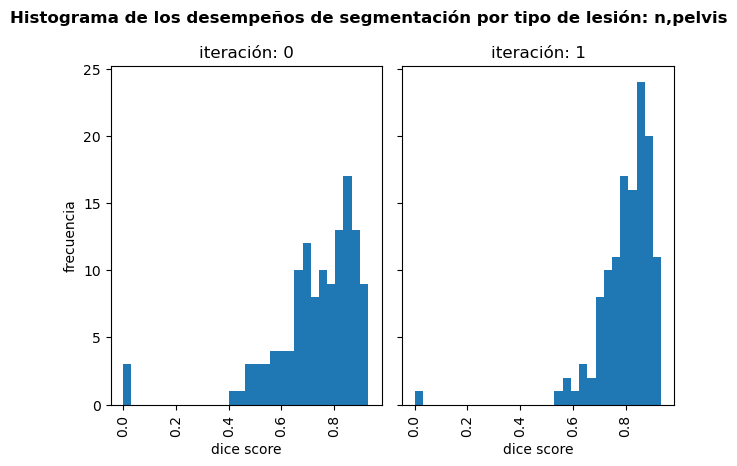

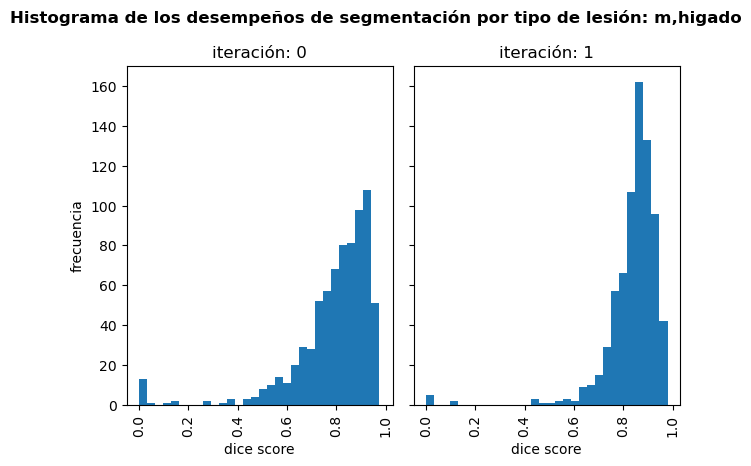

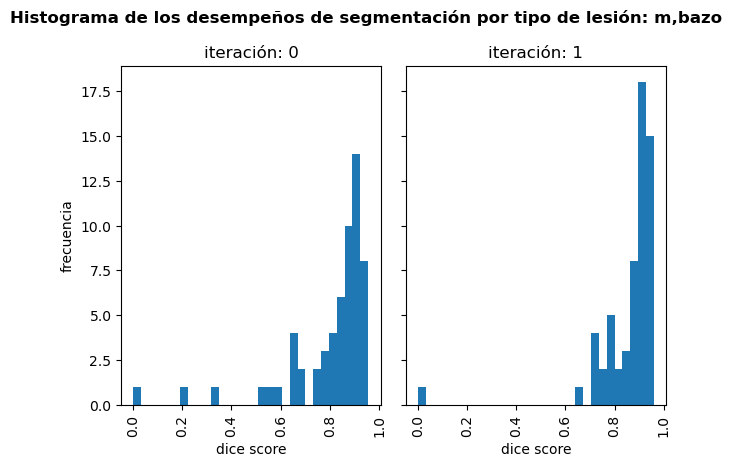

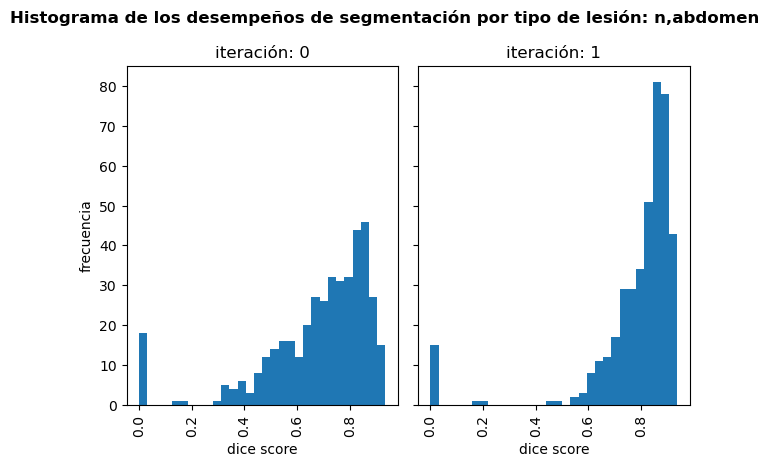

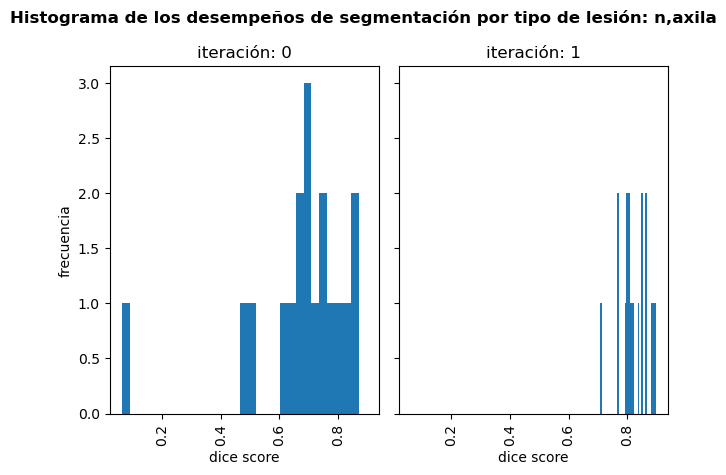

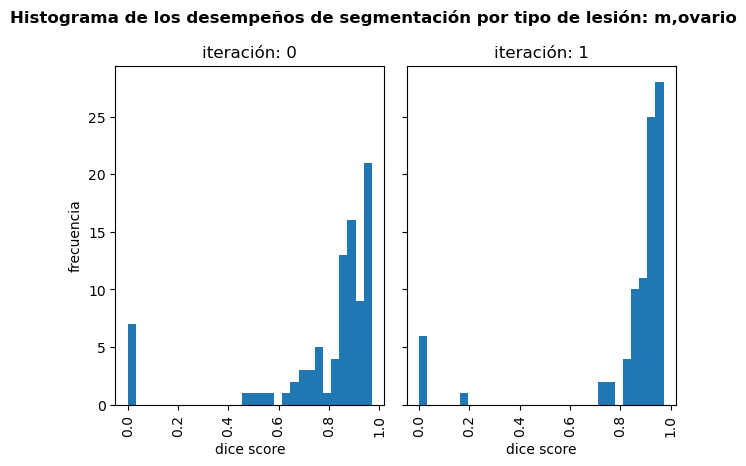

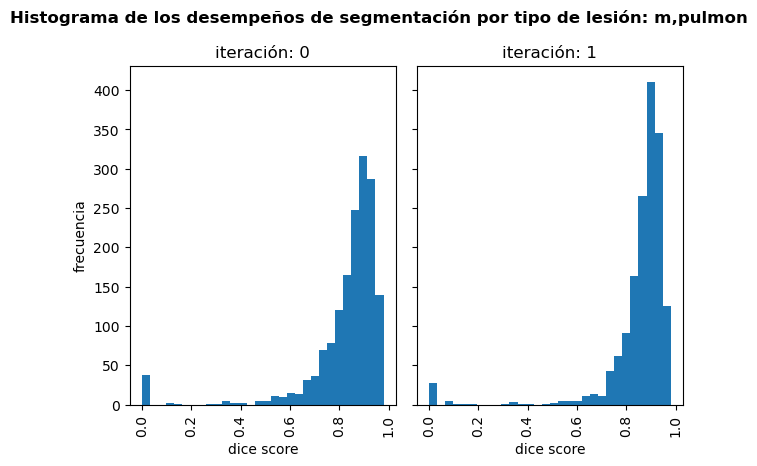

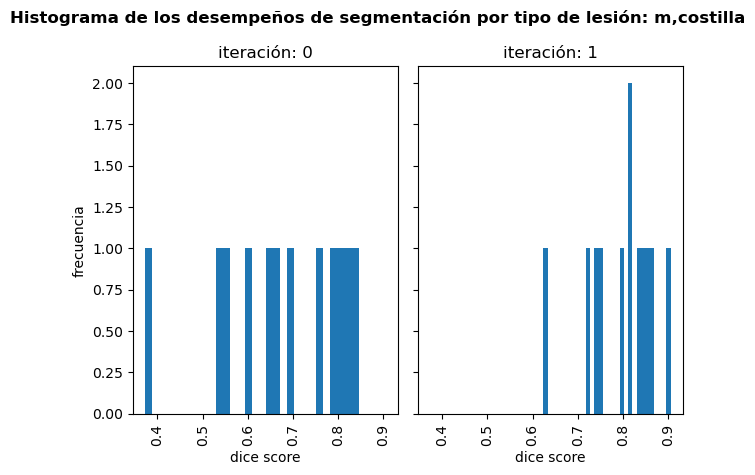

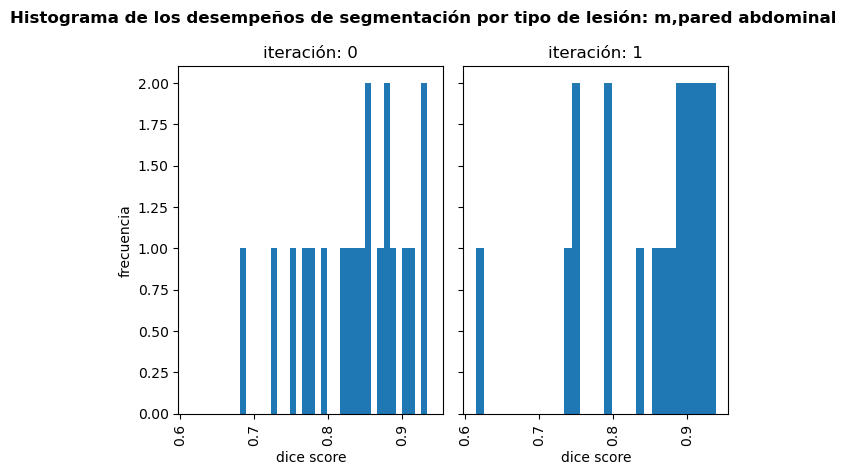

In [11]:
# Histogram of Dice score for each iteration, dissagregated by lesion type
for lesion in unique_lesions:
    fig, ax = plt.subplots(nrows=1, ncols=iterations_count, sharex=True, sharey=True)
    fig.suptitle(
        f'Histograma de los desempeños de segmentación por tipo de lesión: {lesion}',
        fontweight='bold'
    )
    performance_df[performance_df['label_description'] == lesion].hist(
        column='dice_score',
        by='iteration',
        bins=30,
        ax=ax
    )
    ax[0].set_ylabel('frecuencia')
    for idx in range(iterations_count):
        ax[idx].set_xlabel('dice score')
        ax[idx].set_title(f"iteración: {iterations[idx]}")
    plt.tight_layout()
    plt.show()

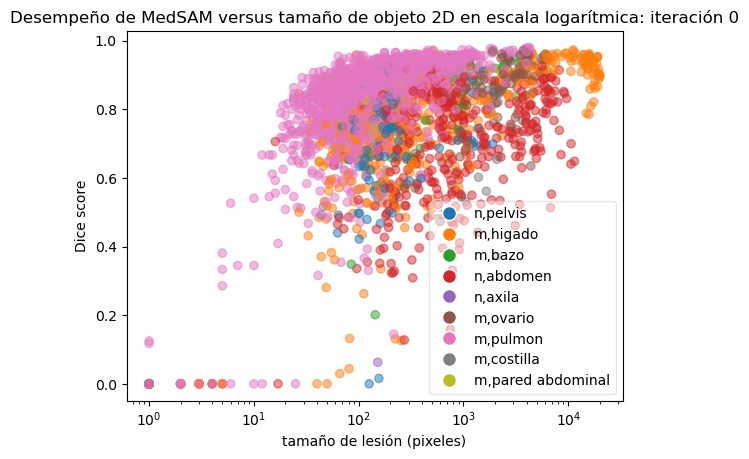

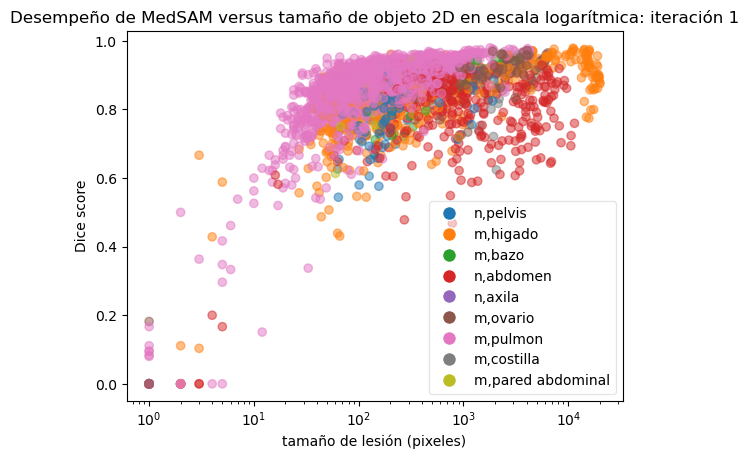

In [12]:
# Scatterplot of Dice versus object size, one plot for each iteration
iterations = list(performance_df['iteration'].unique())
# Add a color for each unique label description
cmap = plt.get_cmap('tab10')
color_mapping = {
    label: cmap(idx)
    for idx, label in enumerate(unique_lesions)
}
for iteration in iterations:
    _, ax = plt.subplots()
    filtered_df = performance_df[performance_df['iteration'] == iteration]
    colors = filtered_df["label_description"].map(color_mapping)
    ax.scatter(
        filtered_df['annotated_pixels'],
        filtered_df['dice_score'],
        c=colors.to_list(),
        label=filtered_df["label_description"],
        alpha=0.5
    )
    ax.set_xscale('log')
    ax.set_title(f'Desempeño de MedSAM versus tamaño de objeto 2D en escala logarítmica: iteración {iteration}')
    ax.set_xlabel('tamaño de lesión (pixeles)')
    ax.set_ylabel('Dice score')
    # Create legend labels based on unique values in 'label_description' column
    legend_labels = [
        Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_mapping[value], label=value)
        for value in unique_lesions
    ]
    ax.legend(handles=legend_labels, framealpha=0.5)
    #plt.savefig(
    #    Path.cwd() / "resources" / f"scatterplot_performance_vs_object_size_hitl_iteration_{iteration}.png",
    #    transparent=True,
    #    bbox_inches='tight'
    #)
    plt.show()

In [13]:
# Hypothesis testing for all dice scores
iteration_a_idx = 0
iteration_b_idx = 1
ttest_result, new_df = run_paired_t_test(performance_df)
difference = new_df[f'dice_score_iteration_{iteration_b_idx}'] - new_df[f'dice_score_iteration_{iteration_a_idx}']
difference_sample_mean = np.mean(difference)
difference_sample_std = np.std(difference)
print(f"p value: {ttest_result.pvalue}")
print(f"difference sample mean: {difference_sample_mean}")
print(f"confidence interval: [{ttest_result.confidence_interval().low}, {ttest_result.confidence_interval().high}]")

p value: 7.351311741827426e-152
difference sample mean: 0.0455752567382193
confidence interval: [0.04235939456266787, 0.04879111891377073]


In [14]:
# Hypothesis testing for scores grouped by lesion type
for lesion in unique_lesions:
    filtered_df = performance_df[performance_df['label_description'] == lesion]
    ttest_result, new_df = run_paired_t_test(filtered_df)
    difference = new_df[f'dice_score_iteration_{iteration_b_idx}'] - new_df[f'dice_score_iteration_{iteration_a_idx}']
    difference_sample_mean = np.mean(difference)
    difference_sample_std = np.std(difference)
    print(f"lesion: {lesion}")
    print(f"p value: {ttest_result.pvalue}")
    print(f"difference sample mean: {difference_sample_mean}")
    print(f"confidence interval: [{ttest_result.confidence_interval().low}, {ttest_result.confidence_interval().high}]")
    print("-"*70)

lesion: n,pelvis
p value: 6.328086925241356e-13
difference sample mean: 0.07323826946566721
confidence interval: [0.05516114547111346, 0.09131539346022095]
----------------------------------------------------------------------
lesion: m,higado
p value: 1.5238423231077975e-36
difference sample mean: 0.04948614258379243
confidence interval: [0.04220254171665629, 0.05676974345092856]
----------------------------------------------------------------------
lesion: m,bazo
p value: 9.416875271340175e-06
difference sample mean: 0.058458600008125645
confidence interval: [0.03436432196431631, 0.08255287805193498]
----------------------------------------------------------------------
lesion: n,abdomen
p value: 7.3263401313950195e-56
difference sample mean: 0.10414367120080154
confidence interval: [0.09303312512675328, 0.11525421727484979]
----------------------------------------------------------------------
lesion: n,axila
p value: 0.0038038888716750755
difference sample mean: 0.1489834205772032


**Warning**: Existe una pequeña cantidad de ROIs (bounding boxes de objetos 2D) que están presentes en una iteración del HITL, pero no en las otras. Esta cantidad es del orden 1-5 ROIs.

**TODO**: Revisar dichos bounding boxes para cada iteración. Recordar que provienen del conjunto de test y de la ejecución del script `evaluate_CT_dataset.py` en [este repositorio](https://github.com/robertorojasp06/MedSAM).

In [15]:
# Get the dataframe with the performance difference between iterations
iterations = [0, 1]
pivot_df = performance_df[performance_df['iteration'].isin(iterations)].pivot(
    index=['bbox_original_fname', 'label_description', 'annotated_pixels'],
    columns='iteration',
    values='dice_score'
)
first_it_name = f"dice_iteration_{iterations[0]}"
second_it_name = f"dice_iteration_{iterations[1]}"
pivot_df.rename(
    columns={
        iterations[0]: first_it_name,
        iterations[1]: second_it_name
    },
    inplace=True
)
pivot_df['dice_difference'] = pivot_df[second_it_name] - pivot_df[first_it_name]
pivot_df.reset_index(inplace=True)
#pivot_df.to_csv(Path.cwd() / 'resources' / f'performance_difference_it{iterations[1]}_vs_it{iterations[0]}.csv', index=False)